In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data

In [2]:
import deeptriplet.models
import deeptriplet.datasets

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
1


## Load GrabCutdataset

In [4]:
grabcut_root = "/home/yardima/datasets/GrabCut/"

In [5]:
## write the
with open(grabcut_root + "list.txt") as f:
    lines = f.readlines()
    lines = [line.rstrip('\n') for line in lines]
    lines_img = []
    lines_lbl = []
    
    for l in lines:
        lines_img.append("img/"+ l)
        lines_lbl.append('lbl/' + l[:-4] + ".bmp")

with open(grabcut_root + 'dataset.txt', 'w') as file:
    for i in range(50):
        file.write(lines_img[i] + ' ' + lines_lbl[i] + '\n')

In [6]:
with open(grabcut_root + 'dataset.txt') as file:
    lines = file.readlines()
    dataset = [line.rstrip('\n').split() for line in lines]

In [7]:
import PIL
import PIL.Image
import numpy as np

In [8]:
def normalize_image_imagenet(img, channel_order=False):
    if channel_order:
        img[0,:,:] = (img[0,:,:] - 0.485) / 0.229
        img[1,:,:] = (img[1,:,:] - 0.456) / 0.224
        img[2,:,:] = (img[2,:,:] - 0.406) / 0.225
    else:
        img[:,:,0] = (img[:,:,0] - 0.485) / 0.229
        img[:,:,1] = (img[:,:,1] - 0.456) / 0.224
        img[:,:,2] = (img[:,:,2] - 0.406) / 0.225
        
    return img

In [9]:
def load_grabcut(i, dataset, root):
    img = np.array(PIL.Image.open(grabcut_root + dataset[i][0]))
    lbl = np.array(PIL.Image.open(grabcut_root + dataset[i][1]))
    
    img = img.astype(np.float32) / 255
    img = normalize_image_imagenet(img)
    img = np.transpose(img, axes=[2, 0, 1])
    
    lbl[lbl == 255] = 1
    lbl[lbl == 128] = 255
    
    return torch.tensor(img), torch.tensor(lbl)

## Load trained embedding model

In [14]:
model_path_random = "/srv/glusterfs/yardima/runs/deeplabv2/asppl-triplet/run_2/models/class-vgg-pascal_epoch-19.pth"

In [15]:
d1 = torch.load(model_path_random, map_location=lambda storage, loc: storage)

In [16]:
net = deeptriplet.models.DeepLab_VGG(n_classes=45, version="aspp-l")
net = net.cuda()
net.load_state_dict(d1)

In [17]:
net = net.eval().cuda();

## t-SNE samples

In [15]:
import sklearn.manifold

In [16]:
def produce_tsne(net, image, label):
    label_original = label.data.numpy().copy()
    label_original[label_original==255] = 0
    image = image.unsqueeze(0)
    label = label.unsqueeze(0)
    
    fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))

    
    with torch.no_grad():
        image = image.cuda()
        out = net.forward(image)
        #embeddings = out.cpu().data.numpy()
        embeddings = fc8_interp_test(out).cpu()
        
    embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
    labels = label.reshape(-1)
    
    embeddings = embeddings[labels != 255, :]
    labels = labels[labels != 255]

    
    ix = np.random.randint(low=0, high=embeddings.shape[0], size=(500,))
    embeddings_subset = embeddings[ix, :]
    labels_subset = labels[ix]
    
    X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(embeddings_subset)
    
    plt.figure(figsize=(9,4))

    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(image.squeeze(), axes=[1, 2, 0]))

    plt.subplot(1, 3, 2)
    plt.imshow(label_original.reshape(image.shape[2], image.shape[3]))

    plt.subplot(1, 3, 3)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_subset)
    
    out = fc8_interp_test(out).data.cpu().numpy()

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<IPython.core.display.Javascript object>


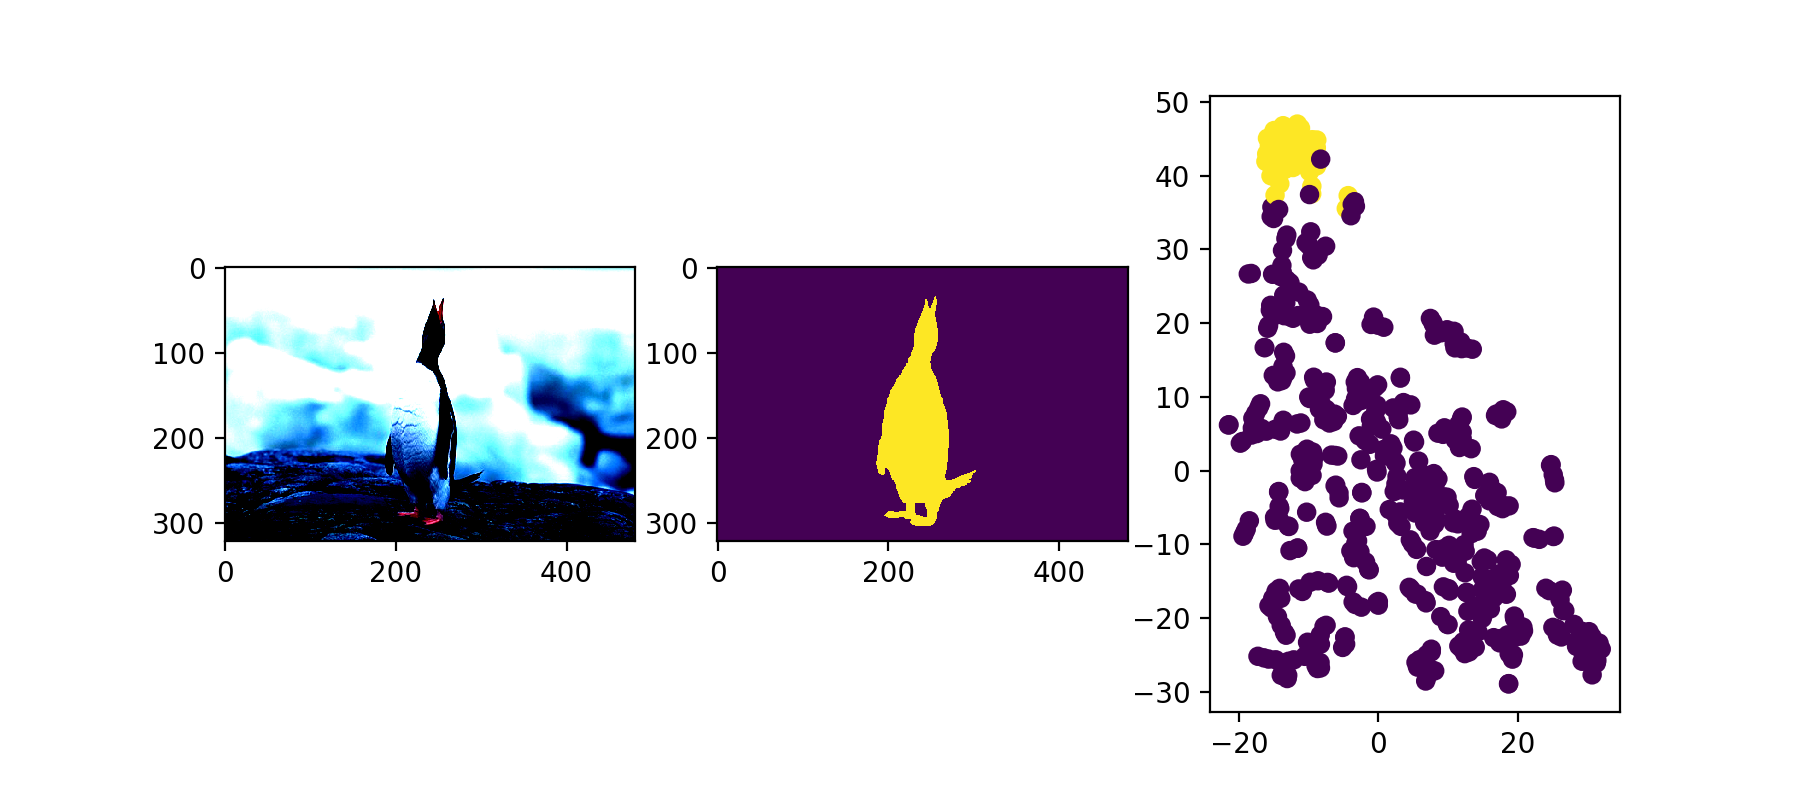

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [18]:
image, label = load_grabcut(0, dataset, grabcut_root)
image, label = torch.tensor(image), torch.tensor(label)
produce_tsne(net, image, label)

<IPython.core.display.Javascript object>


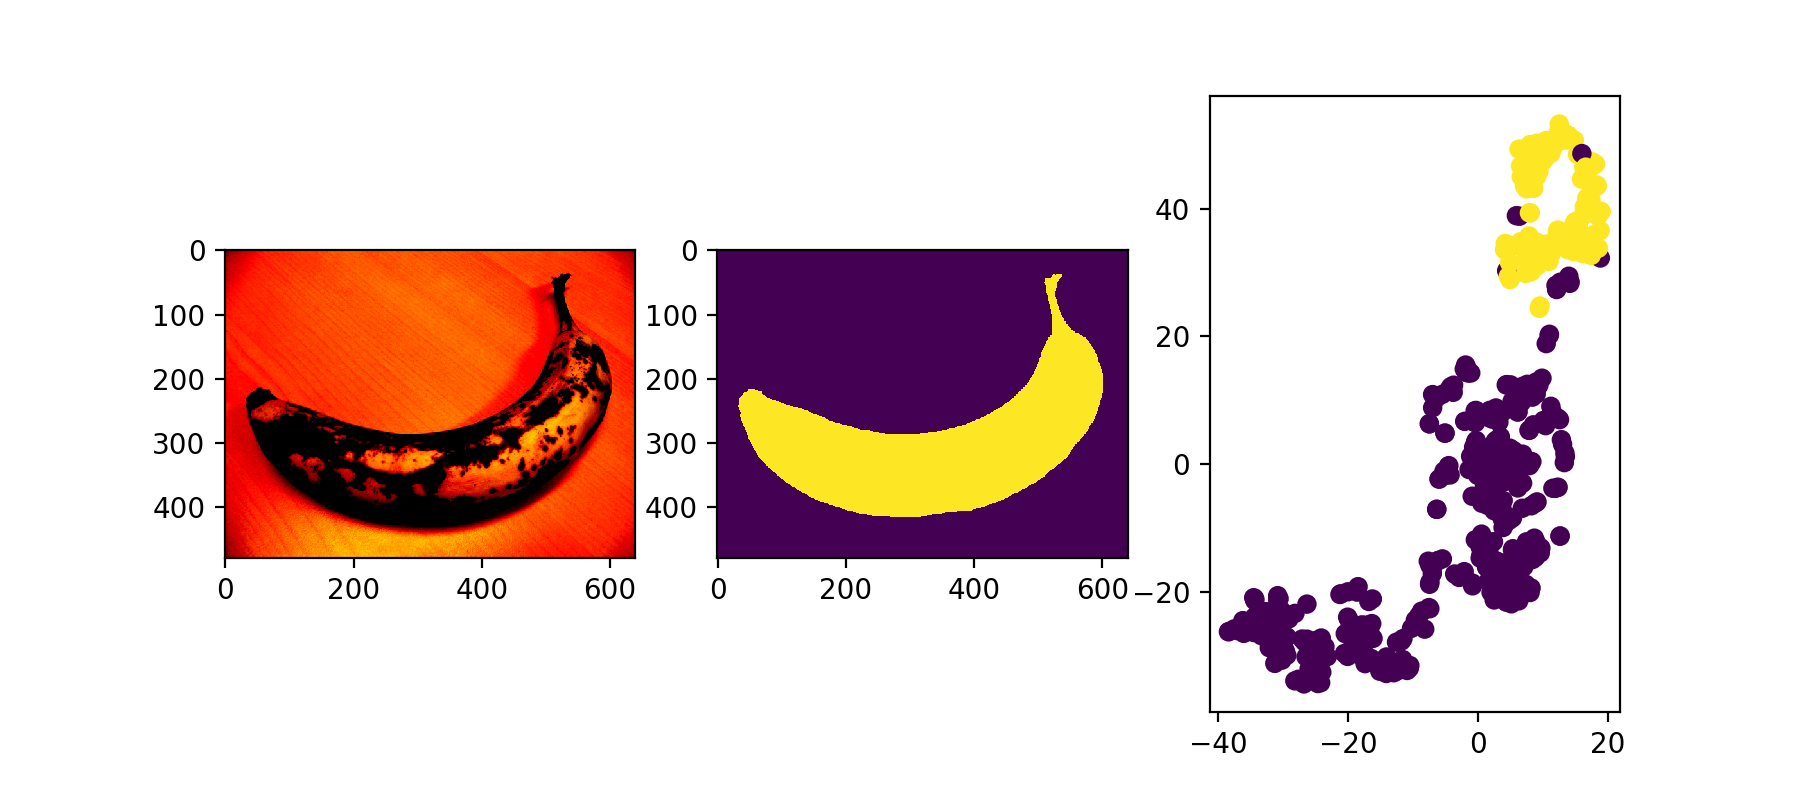

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [19]:
image, label = load_grabcut(20, dataset, grabcut_root)
produce_tsne(net, image, label)

## Color projections

In [20]:
def rvs(dim=3):
    random_state = np.random
    H = np.eye(dim)
    D = np.ones((dim,))
    for n in range(1, dim):
        x = random_state.normal(size=(dim-n+1,))
        D[n-1] = np.sign(x[0])
        x[0] -= D[n-1]*np.sqrt((x*x).sum())
        # Householder transformation
        Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
        mat = np.eye(dim)
        mat[n-1:, n-1:] = Hx
        H = np.dot(H, mat)
        # Fix the last sign such that the determinant is 1
    D[-1] = (-1)**(1-(dim % 2))*D.prod()
    # Equivalent to np.dot(np.diag(D), H) but faster, apparently
    H = (D*H.T).T
    return H

<IPython.core.display.Javascript object>


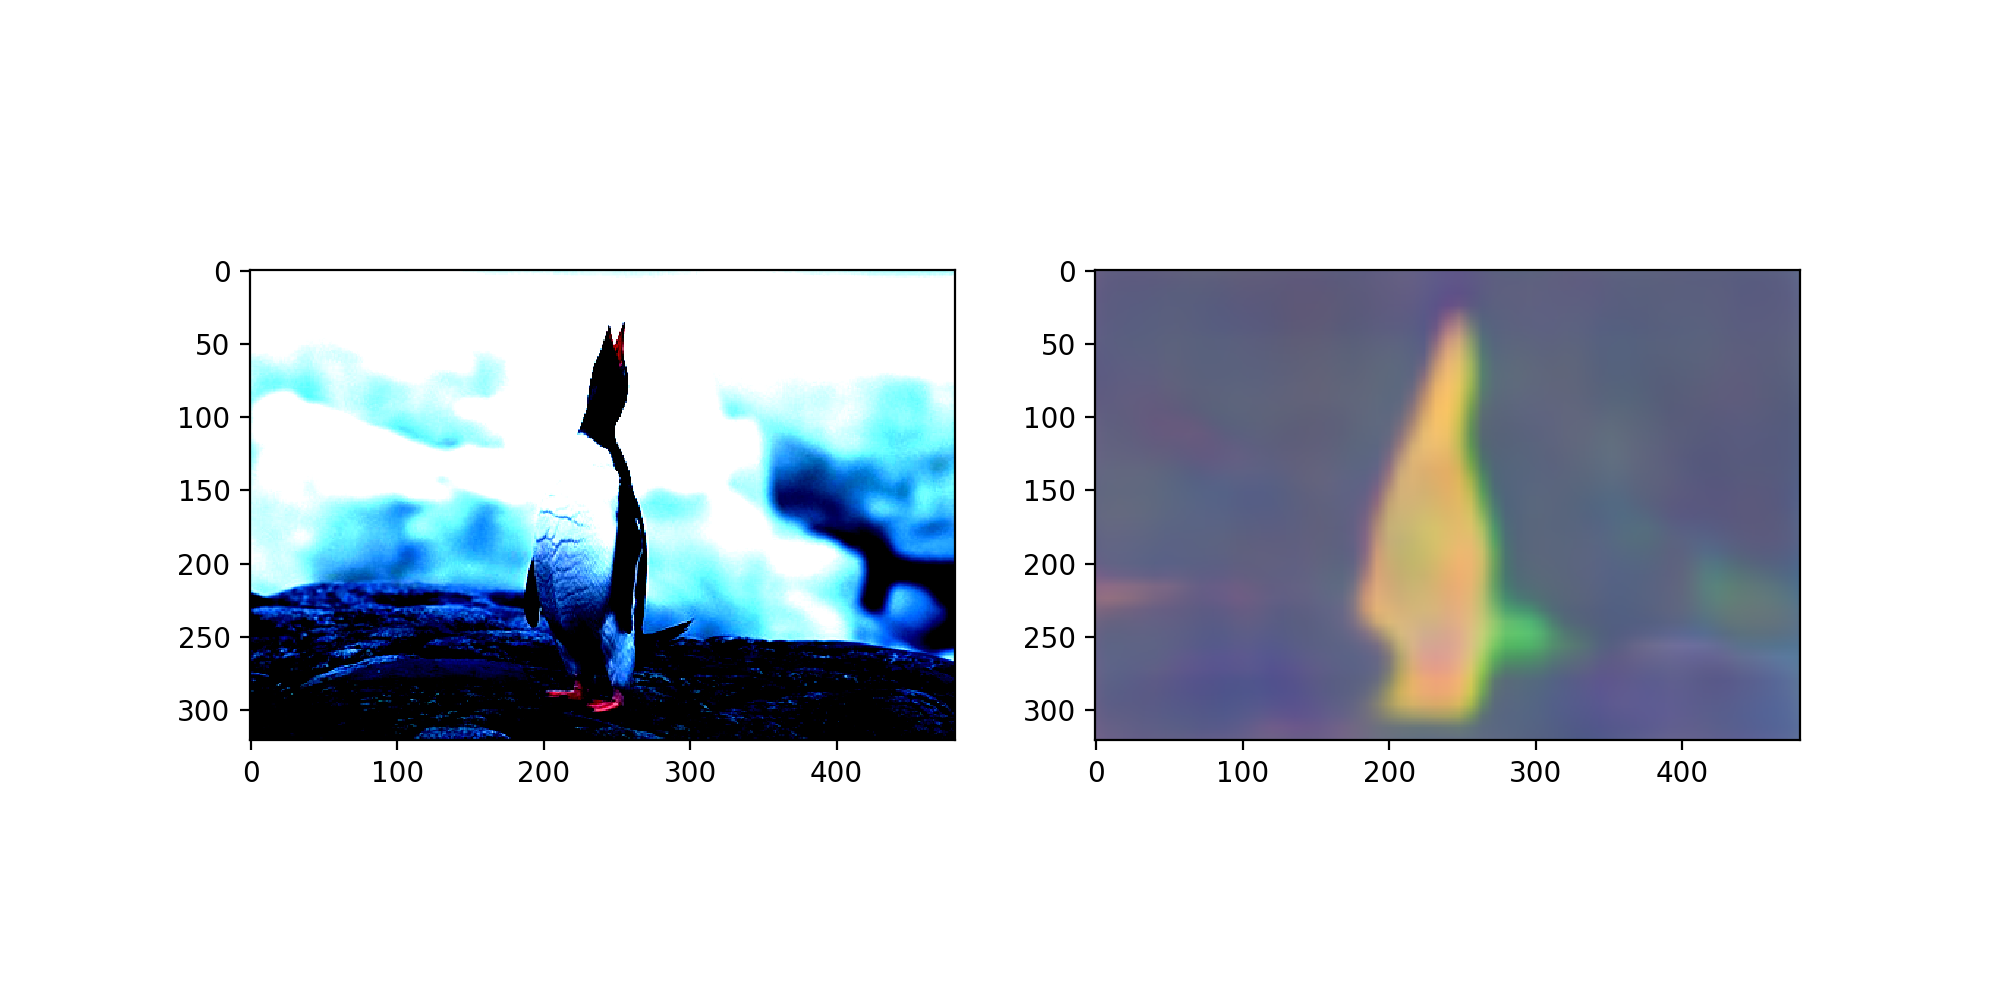

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [21]:
image, label = load_grabcut(0, dataset, grabcut_root)

label_original = label.data.numpy().copy()
label_original[label_original==255] = 0

image = image.unsqueeze(0)
label = label.unsqueeze(0)

fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))

with torch.no_grad():
    image = image.cuda()
    out = net.forward(image)
    #embeddings = out.cpu().data.numpy()
    embeddings = fc8_interp_test(out).cpu()
    
rvo = rvs(45)[:3,:].T
embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
embeddings3 = np.matmul(embeddings, rvo)
embeddings3 = embeddings3.reshape(label.shape[1], label.shape[2], -1)
embeddings3
embeddings3.shape

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(image.squeeze(), axes=[1, 2, 0]))

plt.subplot(1, 2, 2)
plt.imshow(embeddings3 / 1.6 + 0.5)

## Click-precision graph

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
def _fast_hist(label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask],
            minlength=n_class ** 2,
        ).reshape(n_class, n_class)
        return hist

In [20]:
import scipy.ndimage.morphology as morph

In [21]:
import skimage.segmentation

def simulate_clicks_v2_e(model, image, label, n_clicks, *, d_clicks=40, d_margin=20):
    
    def run_clicks(embeddings, labels, clicks, flat=True):
        dim1, dim2 = labels.squeeze().shape

        if not flat:
            clicks = np.array([c[0] * dim2 + c[1] for c in clicks], dtype=np.int32)
            
            embeddings = embeddings.reshape(dim1 * dim2, -1)
            labels = labels.reshape(-1)

        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(embeddings[clicks,:], labels[clicks])

        pred = knn.predict(embeddings)

        cf_matrix = _fast_hist(labels[valid], pred[valid], 2)

        iou = cf_matrix[1,1] / (cf_matrix[0,1] + cf_matrix[1,1] + cf_matrix[1,0])
        acc = np.sum(labels[valid] == pred[valid]) / len(valid)

        return {"pred":pred.reshape(dim1,dim2), 
                "cf":cf_matrix, 
                "iou":iou, 
                "acc":acc}
    
    
    def pick_click(mask):
        candidates = np.transpose(np.nonzero(mask))
        return candidates[np.random.randint(low=0, high=candidates.shape[0]), :]
    
    
    if image.dim() == 3:
        image = image.unsqueeze(0)
    
    if label.dim() == 2:
        label = label.unsqueeze(0)
        
    with torch.no_grad():
        image = image.cuda()
        out = net.forward(image)
        fc8_interp_test = nn.UpsamplingBilinear2d(size=(label.shape[1], label.shape[2]))
        out = fc8_interp_test(out)
        
        embeddings = out.cpu().data.numpy()
        embeddings = np.transpose(embeddings.squeeze(), axes=[1, 2, 0]).reshape(-1, net.n_classes)
        label = label.data.numpy()

        
    label = label.squeeze()
    border = label == 255
    valid = np.nonzero((label.reshape(-1) != 255))[0]
    border2 = morph.binary_dilation(border, iterations=d_margin)
    
    if len(np.unique(label * (1 - border2))) > 1:
        o = np.random.choice(np.sort(np.unique(label * (1 - border2)))[1:])
    else:
        return []
    
    label_obj = (label == o).astype(np.int32)
    
    border = border + morph.binary_dilation(skimage.segmentation.find_boundaries(label_obj), iterations=d_margin)
    
    if not np.any((1 - label_obj) * (1 - border)) or not np.any(label_obj * (1 - border)):
        return []

    click_map = np.zeros(shape=border.shape, dtype=np.int32)

    p1 = pick_click((label_obj) * (1 - border))
    n1 = pick_click((1 - label_obj) * (1 - border))

    click_map[max(p1[0]-d_clicks, 0):p1[0]+d_clicks, max(p1[1]-d_clicks,0):p1[1]+d_clicks] = 1
    click_map[max(n1[0]-d_clicks, 0):n1[0]+d_clicks, max(n1[1]-d_clicks,0):n1[1]+d_clicks] = 1

    clicks = [p1, n1]
    results = []
    results.append(run_clicks(embeddings, label_obj, clicks, flat=False))
    lbl_out = results[-1]['pred']
    err_pixels = np.logical_xor(lbl_out, label_obj)

    for i in range(2, n_clicks):
        
        if not np.any((1 - click_map) * (1 - border)):
            return results
        
        if np.any(err_pixels * (1 - click_map) * (1 - border)):
            c = pick_click(err_pixels * (1 - click_map) * (1 - border))
            click_map[max(c[0]-d_clicks, 0):c[0]+d_clicks, max(c[1]-d_clicks,0):c[1]+d_clicks] = 1
        else:
            c = pick_click((1 - click_map) * (1 - border))
            click_map[max(c[0]-d_clicks, 0):c[0]+d_clicks, max(c[1]-d_clicks,0):c[1]+d_clicks] = 1

        clicks.append(c)
        
        results.append(run_clicks(embeddings, label_obj, clicks, flat=False))
        
        lbl_out = results[-1]['pred']
        err_pixels = np.logical_xor(lbl_out, label_obj)
        
    return results

In [22]:
%%time
trials = 0

n_clicks = 20
mean_acc = np.zeros(n_clicks - 1)
mean_iou = np.zeros(n_clicks - 1)
clicks = 0.0

for i in range(50):
    image, label = load_grabcut(i,dataset, grabcut_root)
    result = simulate_clicks_v2_e(net, image, label, n_clicks)

    if len(result) == n_clicks - 1:
        trials += 1

        mean_acc += np.array([r["acc"] for r in result])
        mean_iou += np.array([r["iou"] for r in result])
        
        iou = np.array([r["iou"] for r in result])
        t = iou > 0.9
        
        if np.any(iou):
            clicks += np.argmax(t) + 2
            print(np.argmax(t) + 2)
        else:
            clicks += 20.0
            print(20)

        print(trials)

mean_acc /= trials
mean_iou /= trials
clicks /= trials

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
1


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


7
2


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
3


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
4


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
5


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


8
6


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
7


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
8


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
9


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
10


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
11


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
12


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
13


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
14


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
15


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
16


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


3
17


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


3
18


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
19


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
20


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


3
21


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
22


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
23


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


8
24


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
25


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
26


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


3
27


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
28


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


10
29


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


3
30


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


3
31


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


5
32


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
33


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
34


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


4
35


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
36


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
37


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


15
38


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
39


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


4
40


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
41


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
42


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
43


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
44


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
45


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
46


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


5
47


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
48


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
49


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


2
50
CPU times: user 4min 41s, sys: 40.2 s, total: 5min 21s
Wall time: 5min 49s


In [23]:
clicks

3.08

In [24]:
print(mean_iou[-1])

0.8590100495719963


<IPython.core.display.Javascript object>


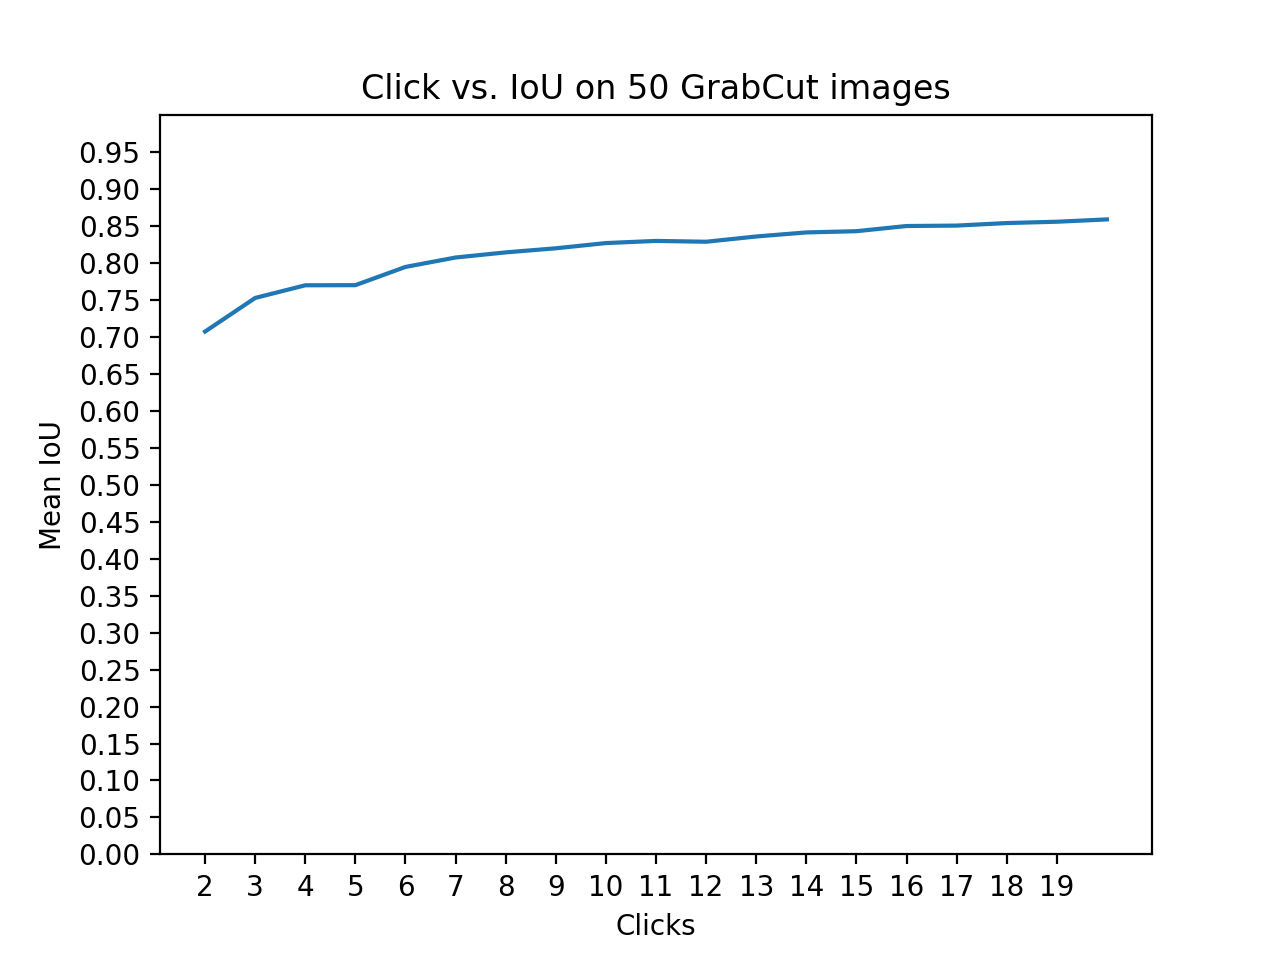

In [25]:
plt.figure()
plt.plot(range(2, 21),mean_iou)
plt.ylim(0,1)
plt.title("Click vs. IoU on 50 GrabCut images")
plt.xlabel("Clicks")
plt.ylabel("Mean IoU")
plt.yticks(np.arange(0.0, 1.0, 0.05))
plt.xticks(np.arange(2.0, 20.0, 1))
mean_iou_base = mean_iou

In [26]:
graphcut = [0, 0.41647, 0.52051, 0.61135, 0.59292 , 0.68515 , 0.73828 , 0.73773 , 0.75957 , 0.76526 , 0.80299 , 0.80789 , 0.83517 , 0.82191 , 0.85346  , 0.8519 , 0.86424 , 0.87155 , 0.87143 , 0.87907 , 0.89611]
geodesicmatting = [0 , 0.23718 , 0.38133  , 0.4326 , 0.55617  , 0.6602 , 0.63506 , 0.68842 , 0.73264  , 0.7581 , 0.79506 , 0.81119 , 0.81285 , 0.82494 , 0.85251 , 0.85958 , 0.86015 , 0.88313 , 0.88004  , 0.8849 , 0.87809]
randomwalker= [0 , 0.24353 , 0.37081 , 0.47507 , 0.56905 , 0.62045 , 0.65946 , 0.73991 , 0.78886 , 0.80488 , 0.81368 , 0.82177 , 0.83732 , 0.87131  , 0.8701  , 0.9013 , 0.88533 , 0.88293 , 0.91703 , 0.90852 , 0.91907]
euclideanstarconvexity = [0 , 0.52075  , 0.5707 , 0.65062 , 0.71197 , 0.77218  , 0.7821  , 0.8171 , 0.83639 , 0.88536 , 0.87501 , 0.87949 , 0.91244 , 0.91596 , 0.90658 , 0.93117  , 0.9282 , 0.90621 , 0.91999 , 0.94405 , 0.94914]
geodesicstarconvexity = [0 , 0.48836 , 0.56403 , 0.66126 , 0.68438 , 0.72558  , 0.7596 , 0.82642 , 0.85716 , 0.85727 , 0.87142 , 0.86295 , 0.91054 , 0.92736 , 0.91775 , 0.93614 , 0.93673 , 0.93886 , 0.94633 , 0.93902  , 0.9558]
growcut = [0 , 0.26565 , 0.36187 , 0.47439 , 0.53135 , 0.58615 , 0.64972 , 0.67848 , 0.68794 , 0.71877 , 0.74829 , 0.76001 , 0.77618 , 0.78652 , 0.80577 , 0.82243 , 0.83948 , 0.85783 , 0.83632 , 0.86645 , 0.85449]
deepios = [0 , 0.62889 , 0.74285 , 0.79842 , 0.83959 , 0.83684  , 0.8625 , 0.88998 , 0.88087 , 0.88309 , 0.91481 , 0.91363 , 0.92075 , 0.92631 , 0.91706 , 0.93541 , 0.93936 , 0.95019 , 0.93832 , 0.95318 , 0.94784]

<IPython.core.display.Javascript object>


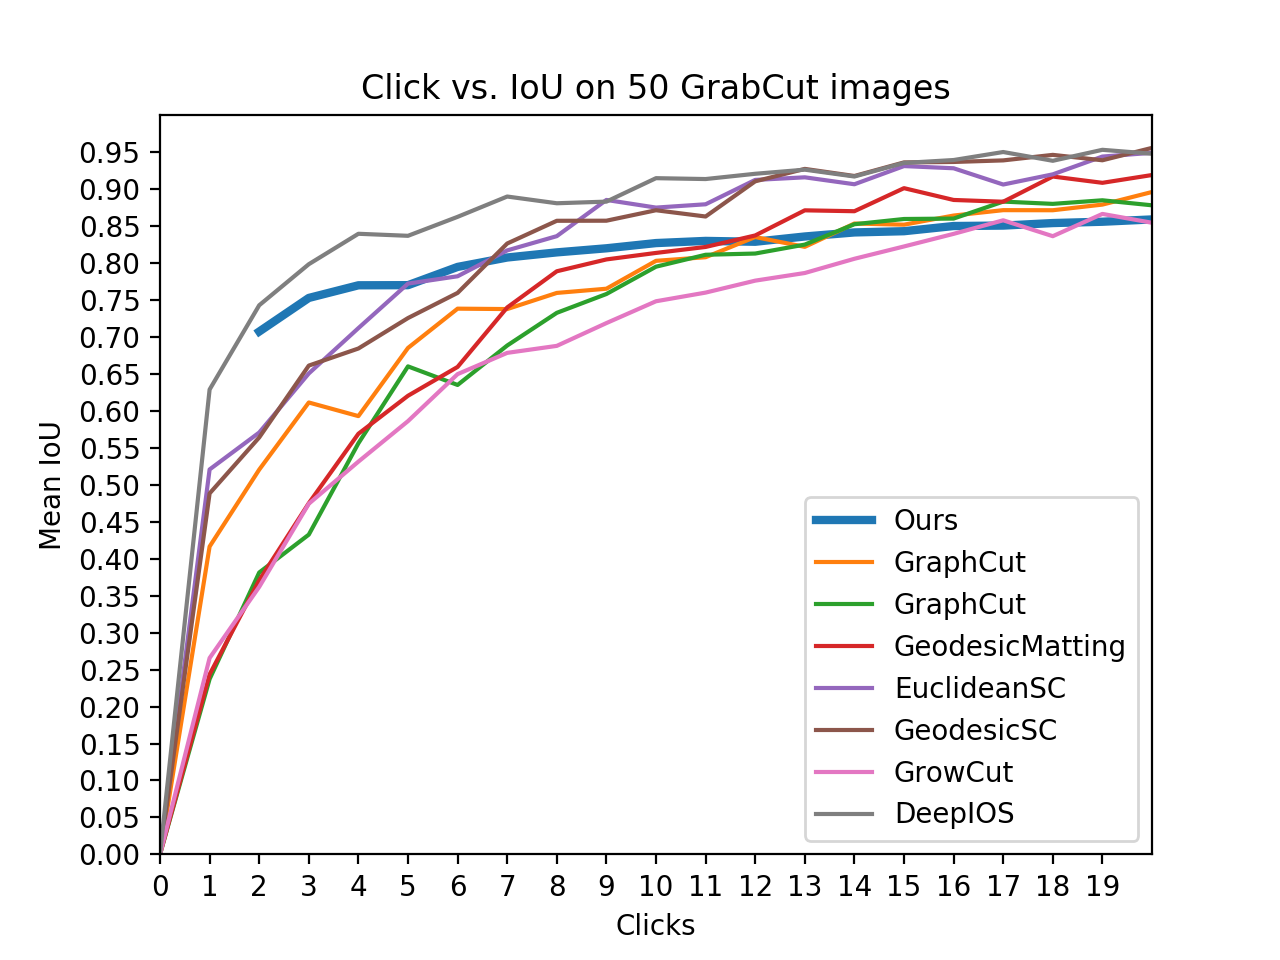

In [27]:
plt.figure()
plt.plot(range(2, 21),mean_iou, label="Ours", linewidth=3.0)

plt.plot(range(0, 21),graphcut, label="GraphCut")
plt.plot(range(0, 21),geodesicmatting, label="GraphCut")
plt.plot(range(0, 21),randomwalker, label="GeodesicMatting")
plt.plot(range(0, 21),euclideanstarconvexity, label="EuclideanSC")
plt.plot(range(0, 21),geodesicstarconvexity, label="GeodesicSC")
plt.plot(range(0, 21),growcut, label="GrowCut")
plt.plot(range(0, 21),deepios, label="DeepIOS")

plt.ylim(0,1)
plt.xlim(0,20)
plt.title("Click vs. IoU on 50 GrabCut images")
plt.xlabel("Clicks")
plt.ylabel("Mean IoU")
plt.yticks(np.arange(0.0, 1.0, 0.05))
plt.xticks(np.arange(0.0, 20.0, 1))
plt.legend()

<IPython.core.display.Javascript object>


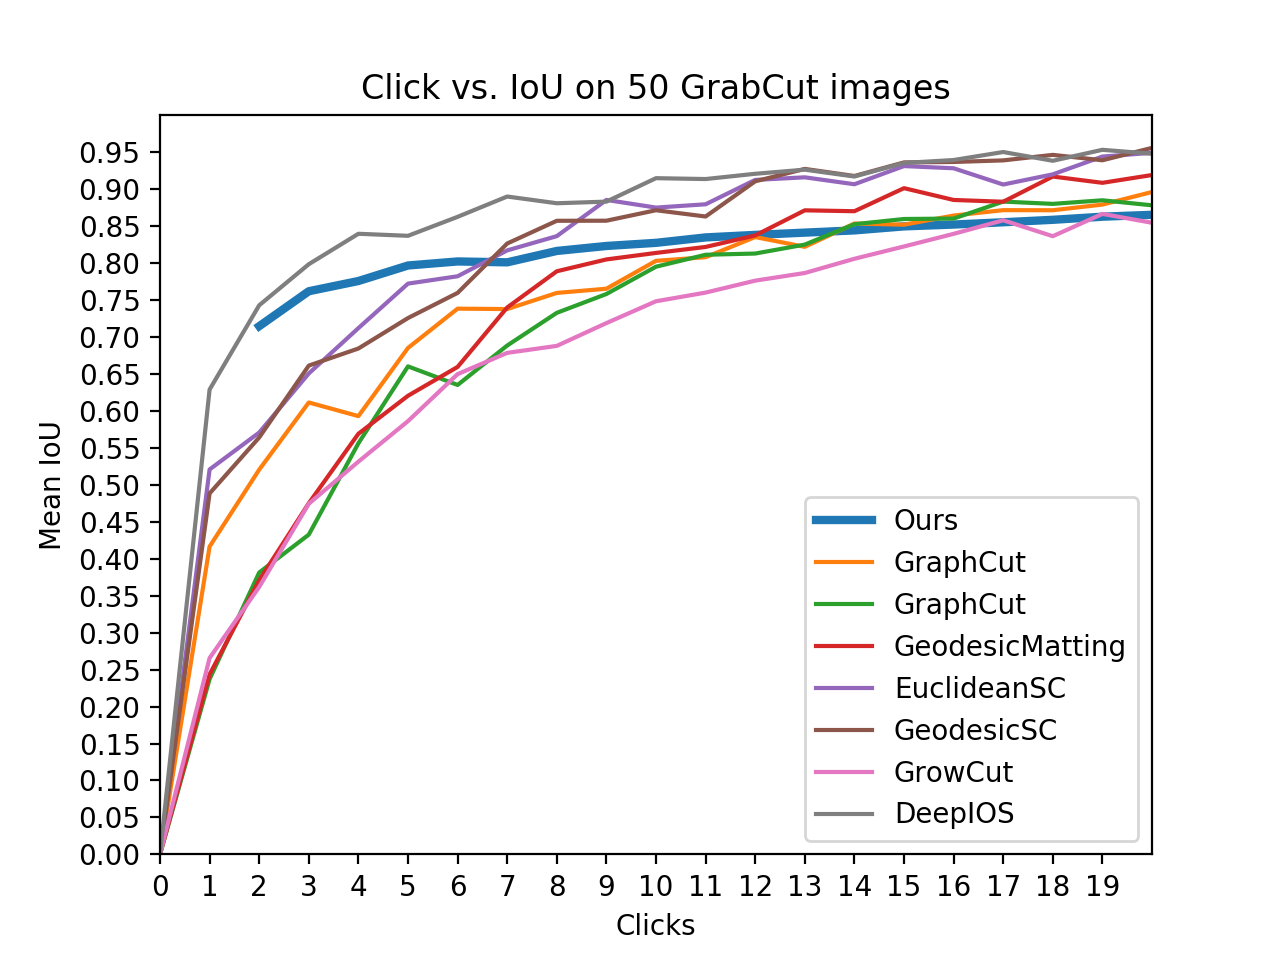

In [46]:
plt.figure()
plt.plot(range(2, 21),mean_iou, label="Ours", linewidth=3.0)

plt.plot(range(0, 21),graphcut, label="GraphCut")
plt.plot(range(0, 21),geodesicmatting, label="GraphCut")
plt.plot(range(0, 21),randomwalker, label="GeodesicMatting")
plt.plot(range(0, 21),euclideanstarconvexity, label="EuclideanSC")
plt.plot(range(0, 21),geodesicstarconvexity, label="GeodesicSC")
plt.plot(range(0, 21),growcut, label="GrowCut")
plt.plot(range(0, 21),deepios, label="DeepIOS")

plt.ylim(0,1)
plt.xlim(0,20)
plt.title("Click vs. IoU on 50 GrabCut images")
plt.xlabel("Clicks")
plt.ylabel("Mean IoU")
plt.yticks(np.arange(0.0, 1.0, 0.05))
plt.xticks(np.arange(0.0, 20.0, 1))
plt.legend()